In [483]:
import numpy as np
import random
from PIL import Image
from matplotlib.pyplot import imshow
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [525]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'RGB'
S = 3

In [526]:
IMG_PATH = './rsz_pic3.jpg'
def load_image(path):
    img = Image.open(path)
    return img.convert(MODE)

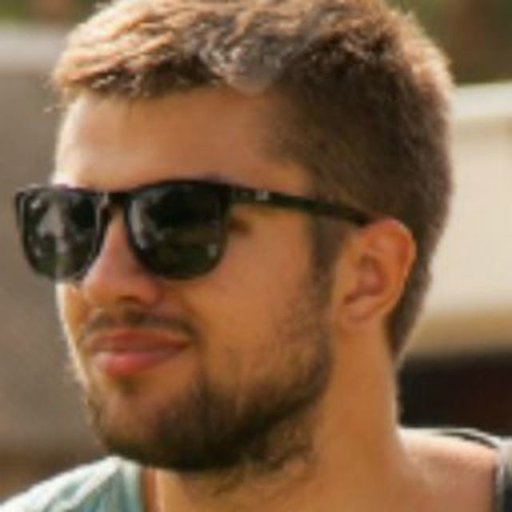

In [527]:
load_image(IMG_PATH)

In [529]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 8, 8
    L = H / n * W / m
    N = n * m * S
    return W, H, n, m, L, N, S

pic = load_image(IMG_PATH)
W, H, n, m, L, N, S = init_hyperparams(pic)
print W, H, L, N, S
# imshow(pic)

512 512 4096 192 3


In [530]:
def encode_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def encode_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return encode_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def decode_area(area):
    C_MAX = 255.0
    return np.array(np.int_(C_MAX * (area + 1.0) / 2.0))

def decode_image(areas):
    if S == 1:
        im_area = np.empty((H, W))
    else:
        im_area = np.empty((H, W, S))
    for i in range(H):
        for j in range(W):
            ii = i / n
            jj = j / m
            idx = ii * (W / m) + jj
            im_area[j][i] = decode_area(areas[idx][(i % n) * m + j % m:(i % n) * m + j % m + S])
    print im_area.shape
    return Image.fromarray(im_area.astype('uint8'), mode=MODE)

def transform_random_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    while True:
        i = np.random.randint(im.height - n)
        j = np.random.randint(im.width - m)
        X = transform(i, j)
        yield X.reshape(1, len(X))
        

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            X = transform(i, j)
            yield i, j, X

In [541]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

In [532]:
im = load_image(IMG_PATH)
tr = transform_random_image(im, n, m)
X = next(tr)
print X.shape
# print X

(1, 192)


In [628]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6.0 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder(object):
    def __init__(self, input_layers=1000, mid_layers=256, lr=1e-2, max_err=1000.0, dynamic_lr=True):
        self.input_layers = input_layers
        self.mid_layers = mid_layers
        self.initializer = glorot_uniform(input_layers, mid_layers)
        self.lr = lr
        self.max_err = max_err
        self.dynamic_lr = dynamic_lr
        self.build()
        
    def error(self, X, Y):
        return (X - Y)**2
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.W1.T
    
    def __call__(self, inp):
        mid, res = self.forward(inp)
        err = self.error(inp, res)
        mean = err.mean()
        if abs(mean) < self.max_err:
            self.backward(inp, mid, res - inp)
            return mean
        else:
            return self.max_err
    
    def forward(self, inp):
        mid = self.encode(inp, self.W1)
        return mid, self.decode(mid, self.W2)
    
    def backward(self, inp, mid, err):
        lr = self.lr
        if self.dynamic_lr:
            lr = 1.0 / np.dot(mid, mid.T)**2
        self.W2 -= lr * np.dot(mid.T, err)
        if self.dynamic_lr:
            lr = 1.0 / np.dot(inp, inp.T)**2
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        
        self.W2 /= np.linalg.norm(self.W2)
        self.W1 /= np.linalg.norm(self.W1)
        
    def encode(self, inp, W1):
        return np.dot(inp, W1)
    
    def decode(self, mid, W2):
        return np.dot(mid, W2)

In [633]:
def try_run(model, epochs, name='', th_err=0.1, viz=True):
    np.random.seed(SEED)
    momentum = 0.95
    errors = []
    gen = transform_random_image(im, n, m)
    best_results = {
        'W1': None,
        'W2': None,
        'min_err': 1e5,
        'epoch': epochs,
    }
    
    def run_iters(pbar=None):
        moving_err = None
        for epoch in range(epochs):
            inp = next(gen)
            err = model(inp)
            moving_err = momentum * moving_err + err * (1. - momentum) if moving_err else err
            if moving_err < best_results['min_err']:
                best_results['min_err'] = moving_err
                best_results['W1'] = model.W1
                best_results['W2'] = model.W2
            errors.append(moving_err)
            if pbar:
                pbar.update(1)
            if best_results['min_err'] < th_err:
                best_results['epoch'] = epoch + 1
                break
        return best_results
    
    if viz:
        with tqdm(total=epochs) as pbar:
            run_iters(pbar)
    else:
        run_iters()
    
    if viz:
        epoch = best_results['epoch']
        x = np.arange(epoch)
        plt.plot(x, np.array(errors))
        idx = np.argmin(errors)
        print("BEST ERROR {} at {}".format(errors[idx], idx))
        plt.title(name)
        plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
        plt.show()
    return best_results
    
def viz_encode(model, best_results):
    W1 = best_results['W1']
    W2 = best_results['W2']
    min_err = best_results['min_err']
    epoch = best_results['epoch']
    
    print 'Showing results for min_err={}. Epoch run: {}'.format(min_err, epoch)
    areas = []
    for i, j, area in transform_image(im, n, m):
        areas.append(model.decode(model.encode(area, W1), W2))
    areas = np.array(areas)
    print areas.shape
    new_pic = decode_image(areas)
#     imshow(new_pic)
    return new_pic

100%|██████████| 500/500 [00:00<00:00, 657.34it/s]


BEST ERROR 0.0550370479547 at 77


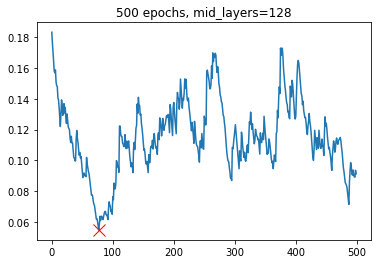

Showing results for min_err=0.0550370479547. Epoch run: 500
(4096, 192)
(512, 512, 3)


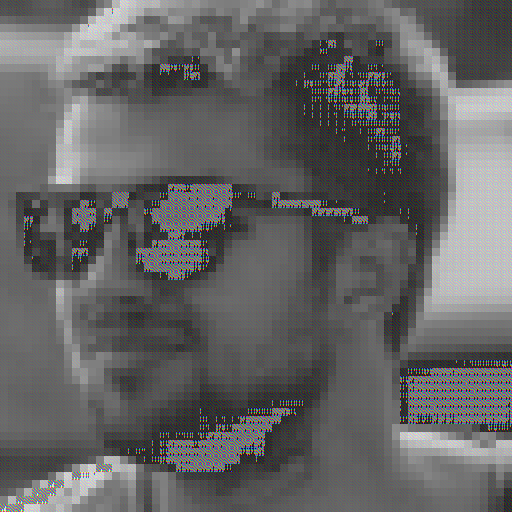

In [634]:
model = Autoencoder(input_layers=N, mid_layers=128)
best_results = try_run(model, 500, '500 epochs, mid_layers=128', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 500/500 [00:01<00:00, 494.41it/s]


BEST ERROR 0.0549988469622 at 77


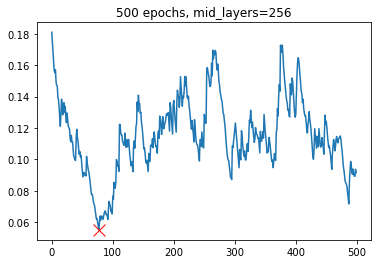

Showing results for min_err=0.0549988469622. Epoch run: 500
(4096, 192)
(512, 512, 3)


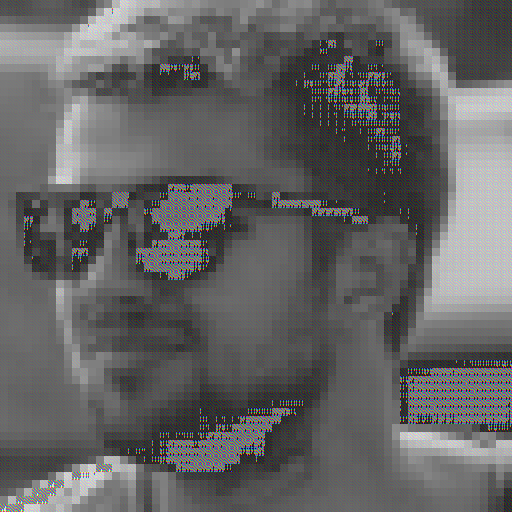

In [635]:
model = Autoencoder(input_layers=N, mid_layers=256)
best_results = try_run(model, 500, '500 epochs, mid_layers=256', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 400/400 [00:01<00:00, 390.47it/s]


BEST ERROR 0.0549988469622 at 77


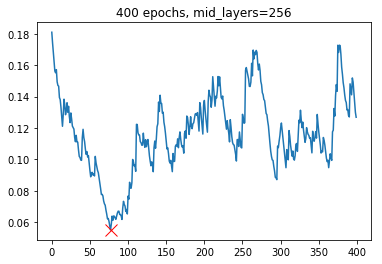

Showing results for min_err=0.0549988469622. Epoch run: 400
(4096, 192)
(512, 512, 3)


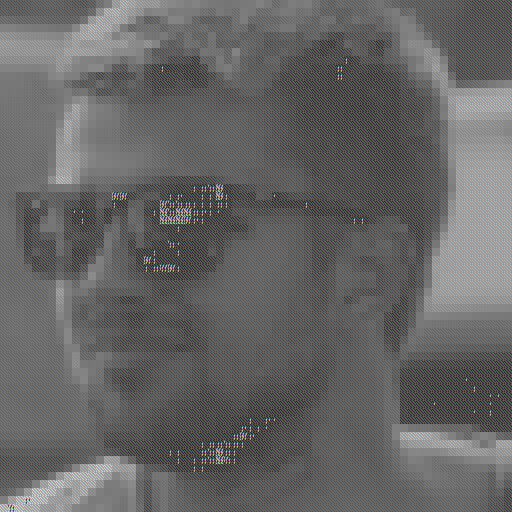

In [636]:
model = Autoencoder(input_layers=N, mid_layers=256)
best_results = try_run(model, 400, '400 epochs, mid_layers=256', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 300/300 [00:00<00:00, 408.49it/s]


BEST ERROR 0.0547066378403 at 77


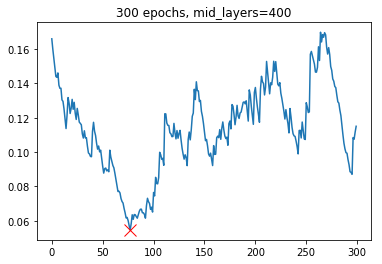

Showing results for min_err=0.0547066378403. Epoch run: 300
(4096, 192)
(512, 512, 3)


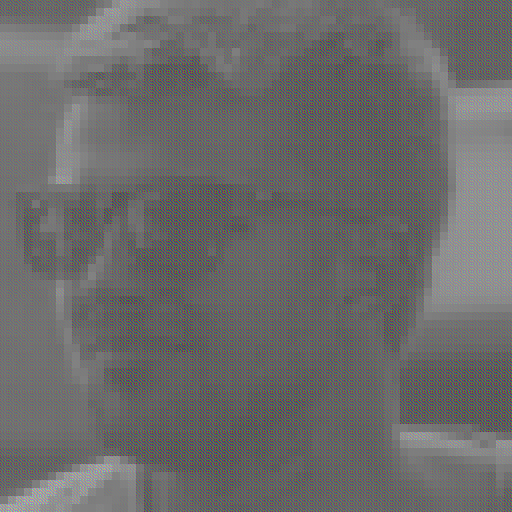

In [637]:
model = Autoencoder(input_layers=N, mid_layers=400)
best_results = try_run(model, 300, '300 epochs, mid_layers=400', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 1000/1000 [00:03<00:00, 318.58it/s]


BEST ERROR 0.054687224366 at 77


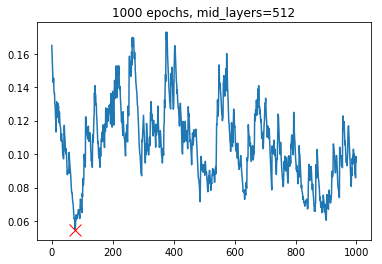

Showing results for min_err=0.054687224366. Epoch run: 1000
(4096, 192)
(512, 512, 3)


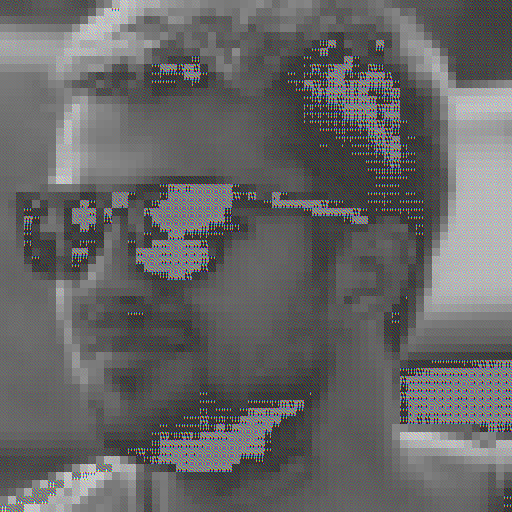

In [638]:
model = Autoencoder(input_layers=N, mid_layers=512)
best_results = try_run(model, 1000, '1000 epochs, mid_layers=512', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 300/300 [00:00<00:00, 303.00it/s]


BEST ERROR 0.0556435671127 at 77


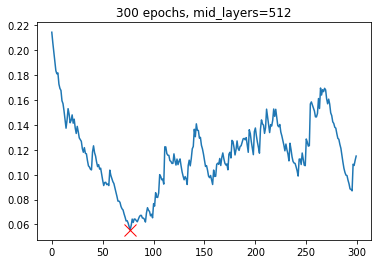

Showing results for min_err=0.0556435671127. Epoch run: 300
(4096, 192)
(512, 512, 3)


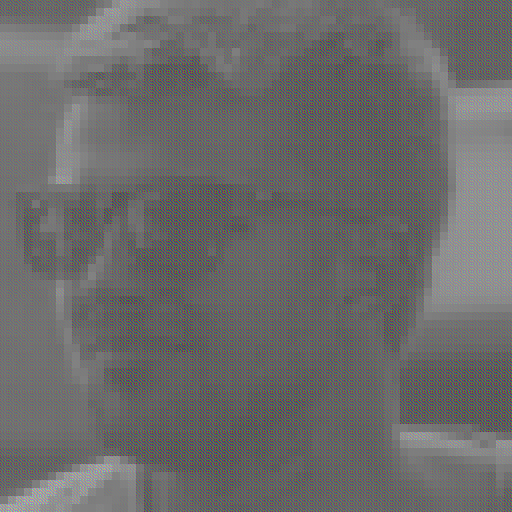

In [639]:
model = Autoencoder(input_layers=N, mid_layers=512)
best_results = try_run(model, 300, '300 epochs, mid_layers=512', 0.001)
new_pic = viz_encode(model, best_results)
new_pic

Best:

In [612]:
def check(**kwargs):
    pic_path = kwargs.get('pic', IMG_PATH)
    pic = load_image(pic_path)
    init_params = ['W', 'H', 'n', 'm', 'L', 'N', 'S']
    default_params = {k: v for (k, v) in zip(init_params, init_hyperparams(pic))}
    params = {
        'epoch': 500,
        'th_err': 0.001,
        'p': 256,
        'dynamic_lr': True,
        'lr': 1e-5,
#         **default_params,
#         **kwargs,
    }
    params.update(default_params)
    params.update(kwargs)
    model = Autoencoder(input_layers=params['N'], mid_layers=params['p'], lr=params['lr'], dynamic_lr=params['dynamic_lr'])
    res = try_run(model, params['epoch'], '{} epochs, mid_layers={}'.format(params['epoch'], params['p']), th_err=params['th_err'], viz=False)
    return res

100%|██████████| 550/550 [00:50<00:00, 10.88it/s]


Min 13 at 2.08830006917


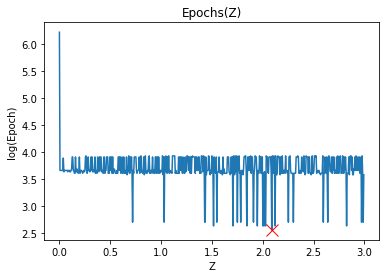

In [613]:
ps = np.arange(550)
epochs = []
for i in tqdm(range(len(ps))):
    epochs.append(check(p=ps[i], th_err=0.1)['epoch'])
idx = np.argmin(epochs)
x = map(partial(get_Z, N, L), ps)
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epochs(Z)')
plt.xlabel('Z')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Min 51 at 0.097


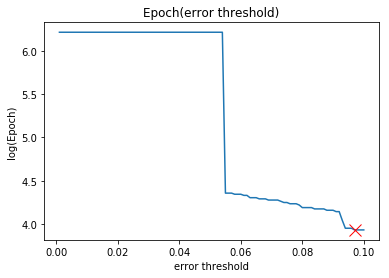

In [625]:
es = np.linspace(0.001, 0.1, 100)
epochs = []
for i in tqdm(range(len(es))):
    epochs.append(check(th_err=es[i])['epoch'])
idx = np.argmin(epochs)
x = es
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epoch(error threshold)')
plt.xlabel('error threshold')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()

100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


Min 35 at 0.00855185929648


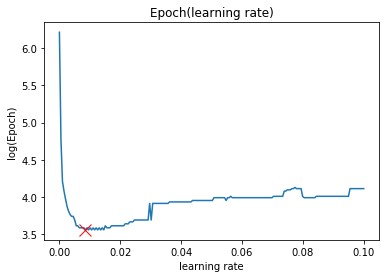

In [627]:
lr = np.linspace(0.00001, 0.1, 200)
epochs = []
for i in tqdm(range(len(lr))):
    epochs.append(check(lr=lr[i], th_err=0.1, dynamic_lr=False)['epoch'])
idx = np.argmin(epochs)
x = lr
y = np.log(epochs)
print 'Min {} at {}'.format(epochs[idx], x[idx])
plt.plot(x, y)
plt.title('Epoch(learning rate)')
plt.xlabel('learning rate')
plt.ylabel('log(Epoch)')
plt.plot(x[idx], y[idx], 'rx--', linewidth=2, markersize=12)
plt.show()